<a href="https://colab.research.google.com/github/vparro/controleAvancado/blob/master/Lotka_Volterra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bibliotecas**

In [1]:
###################################################################################################
#  Bibliotecas gerais
#  Instalação

!pip install xlrd

In [268]:
###################################################################################################
#  Bibliotecas gerais
#  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as npl
from numpy.linalg import matrix_rank

In [ ]:
###################################################################################################
#  Bibliotecas gráfica
#  Instalação

!pip install -U plotly
# !pip install plotly==4.8.1

# organização da planilha excel

!pip install nltk

# Exportando figuras com melhores resoluções

!pip install -U kaleido

!add-apt-repository -y ppa:cran/poppler
!apt-get update
!apt-get install -y libpoppler-cpp-dev
!apt-get install poppler-utils

In [14]:
###################################################################################################
#  Bibliotecas gráfica
# 
# 

import plotly.express as px
import plotly.figure_factory as ff

from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Diretório de imagens
import os
if not os.path.exists("images"):
    os.mkdir("images")


## **Controle**

In [ ]:
###################################################################################################
# Biblioteca de controle e sistemas dinâmicos
# Instalação

!git clone https://github.com/python-control/python-control.git

!pip install slycot   # optional
!pip install control



In [207]:
###################################################################################################
# Biblioteca de controle e sistemas dinâmicos
# 

import control
from control import impulse_response, step_response


# **Funções proprietárias**

In [17]:
def graphics_plot(x, y, y_name, yaxes_title, title='Title', bins=1, x_tick=1, save=False):

  '''
  y = [y1, y2, y3, y4]

  y_name = ['y1 name', 'y2 name', 'y3 name', 'y4 name']

  bins = number of bins for x scale

  title = 'Title'

  yaxes_title = ['Title yaxes1', 'Title yaxes2', 'Title yaxes3', 'Title yaxes4']

  x_tick = dtick for axis x

  save = True -> save graphics as image (images/title.eps) 
  '''

  # Create figure with secondary y-axis
  fig = make_subplots(specs=[[{'secondary_y': True}]])

  # Markers
  markers = ['circle','star','diamond','x']

  # Lines
  dash = ['dash','dot','dashdot']

  for i, v in enumerate(y):
    
    if (len(yaxes_title) == 1) | (i < len(y) - 1):
      on = False
    else:
      on = True

    if i == 0:
      # Add traces
      fig.add_trace(
          go.Scatter(x=x,
          y=v, name=y_name[i],
          marker_symbol=markers[i],
          marker_size=7,
          mode='lines+markers',
          line=dict(color='rgb(0, 0, 0)',
          width=2)),
          # line_shape='spline'),
          secondary_y=False)
      
    else:
      # Add traces
      fig.add_trace(
          go.Scatter(x=x,
          y=v, name=y_name[i],
          marker_symbol=markers[i],
          marker_size=7,
          mode='lines+markers',
          line=dict(color='rgb(0, 0, 0)',
          width=2,dash=dash[i-1])),
          # line_shape='spline'),
          secondary_y=on)
  
  # Add figure title
  fig.update_layout(title_text=title)
  
  # Set x-axis title
  fig.update_xaxes(title_text='Ano relativo')

  # Set y-axes titles
  if len(yaxes_title) > 1:
    fig.update_yaxes(title_text='<b>'+ yaxes_title[0] +'</b>', secondary_y=False)
    fig.update_yaxes(title_text='<b>'+ yaxes_title[1] +'</b>', secondary_y=True)
  else:
    fig.update_yaxes(title_text='<b>'+ yaxes_title[0] +'</b>', secondary_y=False)

  
  fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='black')
  fig.update_yaxes(showgrid=False, gridwidth=1, gridcolor='black')

  fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
  fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)

  fig.update_layout(
      paper_bgcolor='rgba(0,0,0,0)',
      plot_bgcolor='rgba(0,0,0,0)'
  )

  fig.update_layout(
      xaxis=dict(
      tickmode='linear',
      tick0=0,
      dtick=x_tick
  ))

  fig.update_layout(legend=dict(
    orientation='h',
    yanchor='bottom',
    y=1.01,
    xanchor='right',
    x=0.95
  ))

  fig.show()

  if save:
    fig.write_image('images/'+title+'.eps')

# **Dados**

In [5]:
###################################################################################################
#  Dados para análise do modelo

dadosPP = '/content/drive/MyDrive/Colab Notebooks/14 - Roberto/Fur_Pelts_1900_to_1920.xlsx'
dfPP = pd.read_excel(dadosPP,sheet_name='Raw Data')
dfPP.head()

,Year,Hare,Lynx
0,1900,30000,4000
1,1901,47200,6100
2,1902,70200,9800
3,1903,77400,35200
4,1904,36300,59400


In [197]:
###################################################################################################
#  Dados para análise do modelo

hare = np.array(dfPP['Hare']/1000)
lynx = np.array(dfPP['Lynx']/1000)
ano  = np.array(dfPP['Year'] - 1900)

In [198]:
graphics_plot(ano, [hare,lynx], ['presa','predador'],['presa','predador'] , title='Lotka_Volterra', bins=1, x_tick=1, save=False)

# **Modelo**

**Presa - Lebre**

\begin{equation}
\frac{dH(t)}{dt} = \alpha H(t) - \beta H(t) L(t)
\end{equation}

**Predador - Lince**

\begin{equation}
\frac{dL(t)}{dt} = -\gamma L(t) + \delta H(t) L(t)
\end{equation}

In [77]:
###################################################################################################
#  Modelo não linear

def presapredador(t,x,u,parametros):
  """ cria o modelo não linear do fenômeno"""
  
  # Parâmetros iniciais
  a = parametros.get('a', 0.48069)
  b = parametros.get('b', 0.024822)
  c = parametros.get('c', 0.92718)
  d = parametros.get('d', 0.027564)
  u_0 = 0

  # Iniciar os valores de lebres e linces - x_o =[xo1 xo2].T
  H = x[0];
  L = x[1];

  # entrada do sistema - adicionar comida - nunca retirar
  u = u_0 if u > 0 else 0 

  # determinar as equações
  dH = (a + u)*H -b*H*L
  dL = -c*L + d*H*L

  return [dH,dL]

In [78]:
###################################################################################################
#  Criando o subsistema do modelo

io_presapredador = control.NonlinearIOSystem(
    presapredador, None, inputs=('u'), outputs=('H', 'L'),
    states=('H', 'L'), name='presapreda')

In [214]:
###################################################################################################
#  Determinando o ponto de equilíbrio

x0 = [hare[0],lynx[0]]
equilibrio = control.find_eqpt(io_presapredador,x0,0)
equilibrio

(array([33.63735307, 19.36548223]), array([0.]))

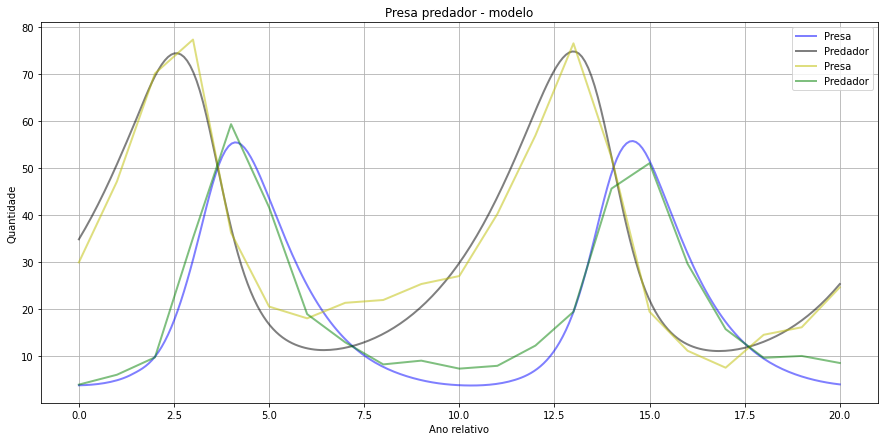

In [125]:
###################################################################################################
# Simulação

x0 = [34.9134,3.8566]  # 
T  = np.linspace(0,20,240)  # vetor de tempo

# Cálculo no tempo 

t, y = control.input_output_response(io_presapredador, T, 0, x0)

plt.figure(figsize=(15,7))
plt.plot(t,y[1],'b', alpha=0.5, lw=2, label='Presa') 
plt.plot(t,y[0],'k', alpha=0.5, lw=2, label='Predador')
plt.plot(ano,hare,'y', alpha=0.5, lw=2, label='Presa')
plt.plot(ano,lynx,'g', alpha=0.5, lw=2, label='Predador')
plt.grid()
plt.legend()
plt.title('Presa predador - modelo')
plt.xlabel('Ano relativo')
plt.ylabel('Quantidade')

plt.show()

# **Projeto de controle**

## **Formulação do problema**

O vetor de funções da dinâmica dos estados representado pela eq. 
(1) é dado de forma mais detalhado como:
\begin{equation}
\left\{ {\begin{array}{l}
 \dot {x}_1 (t)=f_1 \left( {{\rm {\bf x}}(t),{\rm {\bf u}}(t)} \right); \\ 
 \dot {x}_2 (t)=f_2 \left( {{\rm {\bf x}}(t),{\rm {\bf u}}(t)} \right); \\ 
 \vdots \\ 
 \dot {x}_n (t)=f_n \left( {{\rm {\bf x}}(t),{\rm {\bf u}}(t)} \right). \\ 
 \end{array}} \right.
\end{equation}

O vetor de funções da saída representado pela eq. (2) é 
dado de forma mais detalhado como:
\begin{equation}
\left\{ {\begin{array}{l}
 y_1 (t)=g_1 \left( {{\rm {\bf x}}(t),{\rm {\bf u}}(t)} \right); \\ 
 y_2 (t)=g_2 \left( {{\rm {\bf x}}(t),{\rm {\bf u}}(t)} \right); \\ 
 \vdots \\ 
 y_p (t)=g_p \left( {{\rm {\bf x}}(t),{\rm {\bf u}}(t)} \right). \\ 
 \end{array}} \right.
\end{equation}

Dada a condição nominal de operação , expandindo o vetor de funções $\textbf{f}(\textbf{x},\textbf{u})$ em torno de $\textbf{x}_{0}(t)$ e $\textbf{u}_{0}(t)$

$\quad \Rightarrow $ cada equação da dinâmica do sistema: $\dot {x}_i (t)=f_i ({\rm {\bf x}}(t),{\rm {\bf u}}(t))$, para $i = 1 \dots n$, fica:


\begin{equation}
\begin{array}{l}
 \frac{d}{dt}\left( {x_{0,i} (t)+\delta x_i (t)} \right)=f_i \left( {{\rm 
{\bf x}}_{\rm {\bf 0}} (t)+\delta {\rm {\bf x}}(t),{\rm {\bf u}}_{\rm {\bf 
0}} (t)+\delta {\rm {\bf u}}(t)} \right)= \\ 
 \mbox{ }f_i \left( {{\rm {\bf x}}_{\rm {\bf 0}} (t),{\rm {\bf u}}_{\rm {\bf 
0}} (t)} \right)+\left( {\frac{\partial f_i }{\partial {\rm {\bf x}}}} 
\right)_{\rm {\bf 0}} \delta {\rm {\bf x}}(t)+\left( {\frac{\partial f_i 
}{\partial {\rm {\bf u}}}} \right)_{\rm {\bf 0}} \delta {\rm {\bf 
u}}(t)+T.O.S. \\ 
 \end{array}
\end{equation}

Para todas as $n$ equações do sistema, tem-se:
\begin{equation}
\frac{d}{dt}\delta {\rm {\bf x}}(t)=\left[ {\begin{array}{l}
 \left( {\frac{\partial f_1 }{\partial {\rm {\bf x}}}} \right)_0 \\ 
 \left( {\frac{\partial f_2 }{\partial {\rm {\bf x}}}} \right)_0 \\ 
 \vdots \\ 
 \left( {\frac{\partial f_n }{\partial {\rm {\bf x}}}} \right)_0 \\ 
 \end{array}} \right]\delta {\rm {\bf x}}(t)+\left[ {\begin{array}{l}
 \left( {\frac{\partial f_1 }{\partial {\rm {\bf u}}}} \right)_0 \\ 
 \left( {\frac{\partial f_2 }{\partial {\rm {\bf u}}}} \right)_0 \\ 
 \vdots \\ 
 \left( {\frac{\partial f_n }{\partial {\rm {\bf u}}}} \right)_0 \\ 
 \end{array}} \right]\delta {\rm {\bf u}}(t),
\end{equation}
ou mais compactamente,
\begin{equation}
\frac{d}{dt}\delta {\rm {\bf x}}(t)={\rm {\bf A}}(t)\delta {\rm {\bf 
x}}(t)+{\rm {\bf B}}(t)\delta {\rm {\bf u}}(t).
\end{equation}

\begin{equation}
{\rm {\bf A}}(t)=\left[ {{\begin{array}{*{20}c}
 {\left( {\frac{\partial f_1 }{\partial x_1 }} \right)_0 } \hfill & {\left( 
{\frac{\partial f_1 }{\partial x_2 }} \right)_0 } \hfill & \cdots \hfill & 
{\left( {\frac{\partial f_1 }{\partial x_n }} \right)_0 } \hfill \\
 {\left( {\frac{\partial f_2 }{\partial x_1 }} \right)_0 } \hfill & {\left( 
{\frac{\partial f_2 }{\partial x_2 }} \right)_0 } \hfill & \cdots \hfill & 
{\left( {\frac{\partial f_2 }{\partial x_n }} \right)_0 } \hfill \\
 \vdots \hfill & \vdots \hfill & \ddots \hfill & \vdots \hfill \\
 {\left( {\frac{\partial f_n }{\partial x_1 }} \right)_0 } \hfill & {\left( 
{\frac{\partial f_n }{\partial x_2 }} \right)_0 } \hfill & \cdots \hfill & 
{\left( {\frac{\partial f_n }{\partial x_n }} \right)_0 } \hfill \\
\end{array} }} \right]_{(nxn)} 
\end{equation}
\begin{equation}
{\rm {\bf B}}(t)=\left[ {{\begin{array}{*{20}c}
 {\left( {\frac{\partial f_1 }{\partial u_1 }} \right)_0 } \hfill & {\left( 
{\frac{\partial f_1 }{\partial u_2 }} \right)_0 } \hfill & \cdots \hfill & 
{\left( {\frac{\partial f_1 }{\partial u_m }} \right)_0 } \hfill \\
 {\left( {\frac{\partial f_2 }{\partial u_1 }} \right)_0 } \hfill & {\left( 
{\frac{\partial f_2 }{\partial u_2 }} \right)_0 } \hfill & \cdots \hfill & 
{\left( {\frac{\partial f_2 }{\partial u_m }} \right)_0 } \hfill \\
 \vdots \hfill & \vdots \hfill & \ddots \hfill & \vdots \hfill \\
 {\left( {\frac{\partial f_n }{\partial u_1 }} \right)_0 } \hfill & {\left( 
{\frac{\partial f_n }{\partial u_2 }} \right)_0 } \hfill & \cdots \hfill & 
{\left( {\frac{\partial f_n }{\partial u_m }} \right)_0 } \hfill \\
\end{array} }} \right]_{(nxm)} 
\end{equation}

Para todas as $p$ equações de saídas do sistema, tem-se:
\begin{equation}
\delta {\rm {\bf y}}(t)=\left[ {\begin{array}{l}
 \left( {\frac{\partial g_1 }{\partial {\rm {\bf x}}}} \right)_0 \\ 
 \left( {\frac{\partial g_2 }{\partial {\rm {\bf x}}}} \right)_0 \\ 
 \vdots \\ 
 \left( {\frac{\partial g_p }{\partial {\rm {\bf x}}}} \right)_0 \\ 
 \end{array}} \right]\delta {\rm {\bf x}}(t)+\left[ {\begin{array}{l}
 \left( {\frac{\partial g_1 }{\partial {\rm {\bf u}}}} \right)_0 \\ 
 \left( {\frac{\partial g_2 }{\partial {\rm {\bf u}}}} \right)_0 \\ 
 \vdots \\ 
 \left( {\frac{\partial g_p }{\partial {\rm {\bf u}}}} \right)_0 \\ 
 \end{array}} \right]\delta {\rm {\bf u}}(t),
\end{equation}
ou mais compactamente,
\begin{equation}
\delta {\rm {\bf y}}(t)={\rm {\bf C}}(t)\delta {\rm {\bf x}}(t)+{\rm {\bf 
D}}(t)\delta {\rm {\bf u}}(t).
\end{equation}

onde $\textbf{C}(t)$ e $\textbf{D}(t)$ são matrizes dadas por:
\begin{equation}
{\rm {\bf C}}(t)=\left[ {{\begin{array}{*{20}c}
 {\left( {\frac{\partial g_1 }{\partial x_1 }} \right)_0 } \hfill & {\left( 
{\frac{\partial g_1 }{\partial x_2 }} \right)_0 } \hfill & \cdots \hfill & 
{\left( {\frac{\partial g_1 }{\partial x_n }} \right)_0 } \hfill \\
 {\left( {\frac{\partial g_2 }{\partial x_1 }} \right)_0 } \hfill & {\left( 
{\frac{\partial g_2 }{\partial x_2 }} \right)_0 } \hfill & \cdots \hfill & 
{\left( {\frac{\partial g_2 }{\partial x_n }} \right)_0 } \hfill \\
 \vdots \hfill & \vdots \hfill & \ddots \hfill & \vdots \hfill \\
 {\left( {\frac{\partial g_p }{\partial x_1 }} \right)_0 } \hfill & {\left( 
{\frac{\partial g_p }{\partial x_2 }} \right)_0 } \hfill & \cdots \hfill & 
{\left( {\frac{\partial g_p }{\partial x_n }} \right)_0 } \hfill \\
\end{array} }} \right]_{(pxn)} 
\end{equation}
\begin{equation}
{\rm {\bf D}}(t)=\left[ {{\begin{array}{*{20}c}
 {\left( {\frac{\partial g_1 }{\partial u_1 }} \right)_0 } \hfill & {\left( 
{\frac{\partial g_1 }{\partial u_2 }} \right)_0 } \hfill & \cdots \hfill & 
{\left( {\frac{\partial g_1 }{\partial u_m }} \right)_0 } \hfill \\
 {\left( {\frac{\partial g_2 }{\partial u_1 }} \right)_0 } \hfill & {\left( 
{\frac{\partial g_2 }{\partial u_2 }} \right)_0 } \hfill & \cdots \hfill & 
{\left( {\frac{\partial g_2 }{\partial u_m }} \right)_0 } \hfill \\
 \vdots \hfill & \vdots \hfill & \ddots \hfill & \vdots \hfill \\
 {\left( {\frac{\partial g_p }{\partial u_1 }} \right)_0 } \hfill & {\left( 
{\frac{\partial g_p }{\partial u_2 }} \right)_0 } \hfill & \cdots \hfill & 
{\left( {\frac{\partial g_p }{\partial u_m }} \right)_0 } \hfill \\
\end{array} }} \right]_{(pxm)} 
\end{equation}

Se a condição nominal de operação for uma condição de operação em regime, ou seja, ${\rm {\bf \dot {x}}}_{\rm {\bf 0}} (t)={\rm {\bf 0}}$, então as matrizes do sistema, $\textbf{A}, \textbf{B}, \textbf{C}$ e $\textbf{D}$, são constantes e o sitema é do tipo Linear Invariante no Tempo (LIT). Assim a eq. (27) fica:

\begin{equation}
\frac{d}{dt}\partial {\rm {\bf x}}(t)={\rm {\bf A}}\partial {\rm {\bf 
x}}(t)+{\rm {\bf B}}\partial {\rm {\bf u}}(t)
\end{equation}

\begin{equation}
\delta {\rm {\bf y}}(t)={\rm {\bf C}}\delta {\rm {\bf x}}(t)+{\rm {\bf 
D}}\delta {\rm {\bf u}}(t)
\end{equation}

In [220]:
###################################################################################################
# Ponto de equilibrio

xe = equilibrio[0]
He = xe[0]
Le = xe[1]

espaco_estados = control.linearize(io_presapredador,[He,Le],0)

### Recupera as matrizes

A, B, C, D = espaco_estados.A, espaco_estados.B, espaco_estados.C, espaco_estados.D

\begin{equation}
\left(
\begin{array}{rllrll|rll}
-0.&\hspace{-1em}246&\hspace{-1em}\phantom{\cdot}&-0.&\hspace{-1em}413&\hspace{-1em}\phantom{\cdot}&2.&\hspace{-1em}02&\hspace{-1em}\cdot10^{7}\\
0.&\hspace{-1em}78&\hspace{-1em}\phantom{\cdot}&-0.&\hspace{-1em}328&\hspace{-1em}\phantom{\cdot}&0\phantom{.}&\hspace{-1em}&\hspace{-1em}\phantom{\cdot}\\
\hline
1\phantom{.}&\hspace{-1em}&\hspace{-1em}\phantom{\cdot}&0\phantom{.}&\hspace{-1em}&\hspace{-1em}\phantom{\cdot}&0\phantom{.}&\hspace{-1em}&\hspace{-1em}\phantom{\cdot}\\
0\phantom{.}&\hspace{-1em}&\hspace{-1em}\phantom{\cdot}&1\phantom{.}&\hspace{-1em}&\hspace{-1em}\phantom{\cdot}&0\phantom{.}&\hspace{-1em}&\hspace{-1em}\phantom{\cdot}\\
\end{array}\right)
\end{equation}

## **Modelagem em espaço de estados**

Representação da dinâmica de um sistema de ordem  𝑛  usando  𝑛  equações diferenciais de primeira ordem.
Um vetor de dimensão  𝑛 x1  ⇒  chamado vetor de estados
Um vetor de dimensão  𝑚 x1  ⇒  chamado vetor de entradas
Precisa converter a equação diferencial de ordem  𝑛  para  𝑛  equações diferenciais de 1 𝑎  ordem

## Forma geral do espaço dos estados

${\rm {\bf \dot {x}}}(t)={\rm {\bf A}}(t){\rm {\bf x}}(t)+{\rm {\bf 
B}}(t){\rm {\bf u}}(t) \quad \to $ equação dos estados

${\rm {\bf y}}(t)={\rm {\bf C}}(t){\rm {\bf x}}(t)+{\rm {\bf D}}(t){\rm {\bf 
u}}(t) \quad \to $ equação da saída

onde

${\rm {\bf x}}(t)\quad -$ vetor de estados $R^{n}$ (dimensão $n$x1);

${\rm {\bf u}}(t)\quad -$ vetor de entrada $R^{m }$(dimensão $m$x1);

${\rm {\bf y}}(t)\quad -$ vetor de saída $R^{p }$(dimensão $p$x1);

${\rm {\bf A}}(t)\quad -$ matriz de transmissão dos estados ($n$x$n)$;

${\rm {\bf B}}(t)\quad -$ matriz de entrada ($n$x$m)$;

${\rm {\bf C}}(t)\quad -$ matriz de saída ou matriz dos sensores 
($p$x$n)$;

${\rm {\bf D}}(t)\quad -$ matriz de alimentação direta ($p$x$m)$.

Saídas são variáveis associadas com sensores $\Rightarrow $ são variáveis medidas.

Entradas são variáveis que alteram as condições de energia do sistema.

A dinâmica de um sistema pode ser variante ou invariante no tempo:
Sistema linear $\textbf{invariante}$ no tempo $\Rightarrow $ matrizes $\textbf{A}, \textbf{B}, \textbf{C}$ e $\textbf{D}$ são constantes;

Sistema linear $\textbf{variante}$ no tempo $\Rightarrow $ matrizes $\textbf{A}(t), \textbf{B}(t), \textbf{C}(t)$ e $\textbf{D}(t)$ variam no tempo.

Sistemas podem ser:

$\textbf{SISO} \Rightarrow \textit{single}$ (uma) entrada, $\textit{single}$(uma) saída;

$\textbf{MIMO}$ $\Rightarrow $ múltiplas entradas, múltiplas saídas.
\item Usualmente lidamos com Sistemas Lineares Invariantes no tempo (LTI) $\Rightarrow $ relação entre saída (y) e entrada (u) não depende diretamento do tempo.

\begin{equation}
{{\begin{array}{*{20}c}
 {{\rm {\bf \dot {x}}}(t)={\rm {\bf Ax}}(t)+{\rm {\bf Bu}}(t)} \hfill \\
 {{\rm {\bf y}}(t)={\rm {\bf Cx}}(t)+{\rm {\bf Du}}(t)} \hfill \\
\end{array} }} 
\end{equation}

Nesse caso as matrizes $\textbf{A}, \textbf{B}, \textbf{C}$ e $\textbf{D}$ são constantes.

Saídas futuras dependem somente do estado presente e entradas futuras.

Não existe somente um conjunto de estados para um mesmo sistema $\Rightarrow $ existem muitas possibilidades para o vetor de estados de um sistema.
 


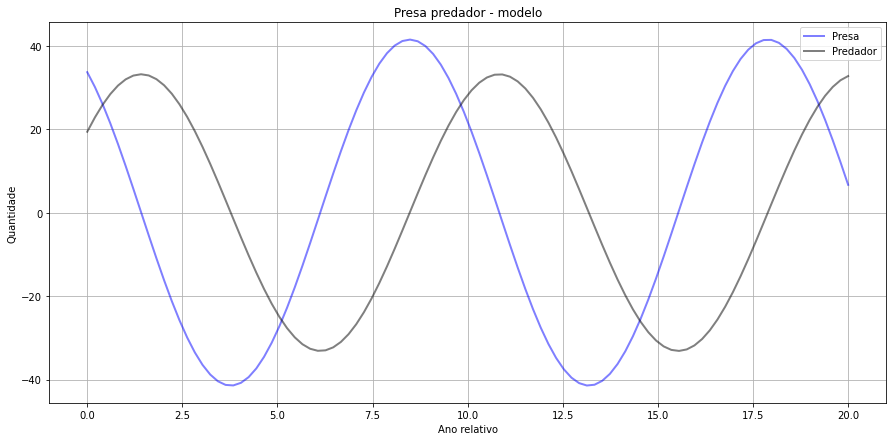

In [257]:
###################################################################################################
# Simulando o modelo linear

Sistema =  control.ss(A,B,C,D)
T, yout = step_response(Sistema, 20, X0= [He,Le],)


plt.figure(figsize=(15,7))
plt.plot(T,yout[0][0],'b', alpha=0.5, lw=2, label='Presa') 
plt.plot(T,yout[1][0],'k', alpha=0.5, lw=2, label='Predador')
plt.grid()
plt.legend()
plt.title('Presa predador - modelo')
plt.xlabel('Ano relativo')
plt.ylabel('Quantidade')

plt.show()


# **Forma diagonal**


O vetor de estados não é único para um sistema dinâmico $\Rightarrow $ existem inúmeras possibilidades de definir o vetor de estado para um mesmo sistema dinâmico;

Cada vetor de estado vai gerar uma forma diferente de SS (espaço de estados) para uma mesma FT.

Existem algumas formas clássicas de representação no espaço dos estados.


## **Formas canônicas**

Cada uma dessas formas é útil para um determinado objetivo.

1.   Controlável;
2.   Observável;
3.   Jordan;
4.   Diagonal ou modal.

Forma mais importante para análise de sistemas dinâmicos LIT $\Rightarrow $ diagonal ou modal $\Rightarrow $ permite visualizar facilmente a dinâmica do sistema.

Matricialmente as expressões no tempo podem ser escritas na forma SS 
diagonal, ou seja:

\begin{equation}
\begin{array}{l}
 \left[ {\begin{array}{l}
 \dot {x}_1 (t) \\ 
 \dot {x}_2 (t) \\ 
 \vdots \\ 
 \dot {x}_n (t) \\ 
 \end{array}} \right]=\left[ {{\begin{array}{*{20}c}
 {p_1 } \hfill & 0 \hfill & \cdots \hfill & 0 \hfill \\
 0 \hfill & {p_2 } \hfill & \cdots \hfill & 0 \hfill \\
 \vdots \hfill & \vdots \hfill & \ddots \hfill & \vdots \hfill \\
 0 \hfill & 0 \hfill & \cdots \hfill & {p_n } \hfill \\
\end{array} }} \right]\left[ {\begin{array}{l}
 x_1 (t) \\ 
 x_2 (t) \\ 
 \vdots \\ 
 x_n (t) \\ 
 \end{array}} \right]+\left[ {\begin{array}{l}
 r_1 \\ 
 r_2 \\ 
 \vdots \\ 
 r_n \\ 
 \end{array}} \right]u(t) \\ 
 y(t)=\left[ {{\begin{array}{*{20}c}
 1 \hfill & 1 \hfill & \cdots \hfill & 1 \hfill \\
\end{array} }} \right]\left[ {\begin{array}{l}
 x_1 (t) \\ 
 x_2 (t) \\ 
 \vdots \\ 
 x_n (t) \\ 
 \end{array}} \right] \\ 
 \end{array}
\end{equation}


Nota-se que a matriz A é diagonal e a sua diagonal são os pólos do sistema.


In [258]:
###################################################################################################
# Analisando os polos e zeros do sistema

control.pole(Sistema)
control.zero(Sistema)
control.damp(Sistema)

_____Eigenvalue______ Damping___ Frequency_
         0   +0.6676j         -0     0.6676
         0   -0.6676j         -0     0.6676


(array([0.6675973, 0.6675973]),
 array([-0., -0.]),
 array([0.+0.6675973j, 0.-0.6675973j]))

# **Transformação linear**

 Dado um sistema LIT na forma do espaço dos estados:
 
 \begin{equation}
\left\{ {\begin{array}{l}
 {\rm {\bf \dot {x}}}(t)={\rm {\bf Ax}}(t)+{\rm {\bf Bu}}(t) \\ 
 {\rm {\bf y}}(t)={\rm {\bf Cx}}(t)+{\rm {\bf Du}}(t) \\ 
 \end{array}} \right.
\end{equation}

**Pergunta-se, qual a Função de Transfer\^{e}ncia correspondente?**


Aplicando a Transformada de Laplace na equação da dinâmica dos 
estados,
\begin{equation}
L\left\{ {{\rm {\bf \dot {x}}}(t)} \right\}=L\left\{ {{\rm {\bf Ax}}(t)+{\rm 
{\bf Bu}}(t)} \right\}
\end{equation}
Assumindo condições iniciais iguais a zero (por definição a 
FT tem condições inciais iguais a zero), tem-se:
\begin{equation}
s{\rm {\bf X}}(s)={\rm {\bf AX}}(S)+{\rm {\bf BU}}(s)
\end{equation}

Rearranjando,
\begin{equation}
\left( {s{\rm {\bf I}}-{\rm {\bf A}}} \right){\rm {\bf X}}(s)={\rm {\bf 
BU}}(s)
\end{equation}
Isolando $\textbf{X}(s)$
\begin{equation}
{\rm {\bf X}}(s)=\left( {s{\rm {\bf I}}-{\rm {\bf A}}} \right)^{-1}{\rm {\bf 
BU}}(s)
\end{equation}

Aplicando a Transformada de laplace da equação das saídas do 
sistema,
\begin{equation}
L\left\{ {{\rm {\bf y}}(t)} \right\}=L\left\{ {{\rm {\bf Cx}}(t)+{\rm {\bf 
Du}}(t)} \right\}
\end{equation}
ou
\begin{equation}
{\rm {\bf Y}}(s)={\rm {\bf CX}}(S)+{\rm {\bf DU}}(s)
\end{equation}


Substituindo as equações, tem-se:
\begin{equation}
{\rm {\bf Y}}(s)={\rm {\bf C}}\left( {s{\rm {\bf I}}-{\rm {\bf A}}} 
\right)^{-1}{\rm {\bf BU}}(s)+{\rm {\bf DU}}(s)
\end{equation}
\begin{equation}
{\rm {\bf Y}}(s)=\left[ {{\rm {\bf C}}\left( {s{\rm {\bf I}}-{\rm {\bf A}}} 
\right)^{-1}{\rm {\bf B}}+{\rm {\bf D}}} \right]{\rm {\bf U}}(s)
\end{equation}


Lembrando que a FT é a relação entre a saída e a entrada do 
sistema, ou seja, \textbf{Y}($s)$/\textbf{U}($s)$,
\begin{equation}
{\rm {\bf G}}(s)={\rm {\bf C}}\left( {s{\rm {\bf I}}-{\rm {\bf A}}} 
\right)^{-1}{\rm {\bf B}}+{\rm {\bf D}}
\end{equation}

$\textbf{G}(s)$ é uma matriz de Funções de Transferência com dimensão $p \;x \; m$ ($p$ = número de saídas e $m$ = número de entradas);

Cada elemento $G_{ij}(s)$ da matriz $\textbf{G}(s)$ descreve a dinâmica da saída $i$ em função da entrada $j$ do sistema $\Rightarrow $ por exemplo, $G_{12}(s)$ descreve a relação dinâmica entre a saída 1 e a entrada 2 do sistema;

Se o sistema tiver somente uma entrada e uma saída $\Rightarrow G(s)$ é um escalar.


Existe um método simples para calcular a FT para sistemas de qualquer ordem que não exige cálculo de inversa de matriz, somente determinante de matrizes:

\begin{equation}
G_{ij} (s)=\frac{\det \left[ {{\begin{array}{*{20}c}
 {s{\rm {\bf I}}-{\rm {\bf A}}} \hfill & {-{\rm {\bf B}}_{\rm {\bf j}} } 
\hfill \\
 {{\rm {\bf C}}_{\rm {\bf i}} } \hfill & {{\rm {\bf D}}_{{\rm {\bf ij}}} } 
\hfill \\
\end{array} }} \right]}{\det \left[ {s{\rm {\bf I}}-{\rm {\bf A}}} \right]}
\end{equation}
onde $\textbf{C}_{i}$ é a $i$-ésima linha da matriz $\textbf{C}$ e 
$\textbf{B}_{j}$ é a $j$-ésima coluna da matriz $\textbf{B}$ e $\textbf{ 
D}_{ij}$ é o elemento $i,j$ da matriz $\textbf{D}$. 


Nota-se que se o sistema for SISO $\Rightarrow  \textbf{C} $
é uma matriz linha e $\textbf{B}$ é uma matriz coluna.


$\textbf{Os denominadores de todos os elementos da matriz de FT, G(s)}$, são iguais $\Rightarrow $ equação característica do sistema.

O cálculo algébrico da inversa de uma matriz nem sempre é um processo simples de realizar. O único caso onde o cálculo da matriz $$(sI- A)^{-1}$$ é simples  para sistemas de ordem 2.

\begin{equation}
{\rm {\bf A}}=\left[ {{\begin{array}{*{20}c}
 {a_{11} } \hfill & {a_{12} } \hfill \\
 {a_{21} } \hfill & {a_{22} } \hfill \\
\end{array} }} \right]
\end{equation}

\begin{equation}
\left( {s{\rm {\bf I}}-{\rm {\bf A}}} \right)^{-1}=\left[ 
{{\begin{array}{*{20}c}
 {s-a_{11} } \hfill & {-a_{12} } \hfill \\
 {-a_{21} } \hfill & {s-a_{22} } \hfill \\
\end{array} }} \right]^{-1}=\frac{1}{det} \left[ {{\begin{array}{*{20}c}
 {s-a_{22} } \hfill & {a_{12} } \hfill \\
 {a_{21} } \hfill & {s-a_{11} } \hfill \\
\end{array} }} \right]
\end{equation}

**Para sistemas de ordem maior do que dois uma opção é usar o método de Cramer $\Rightarrow $ muito trabalhoso.**

O determinante de uma matriz de dimensão $n$x$n$ é calculado pela soma dos 
cofatores da matriz:

\begin{equation}
\det \left[ {{\begin{array}{*{20}c}
 {a_{11} } \hfill & {a_{12} } \hfill & \cdots \hfill & {a_{1n} } \hfill \\
 {a_{21} } \hfill & {a_{22} } \hfill & \cdots \hfill & {a_{2n} } \hfill \\
 \vdots \hfill & \vdots \hfill & \ddots \hfill & \vdots \hfill \\
 {a_{n1} } \hfill & {a_{n2} } \hfill & \cdots \hfill & {a_{nn} } \hfill \\
\end{array} }} \right]_{(nxn)} =a_{11} A_{11} +a_{12} A_{12} +\cdots +a_{1n} 
A_{1n} 
\end{equation}

onde $A_{ij}$ é o cofator dos elemento $a_{ij}$, dado por:

\begin{equation}
A_{ij} =(-1)^{i+j}\det {\rm {\bf D}}_{{\rm {\bf ij}}} 
\end{equation}

# **Observabilidade e controlabilidade**

Um sistema LIT é controlável se existe um vetor de entrada 
$\textbf{u}(t)$ para 0 $\le t \le  \quad T$, com $T  >$ 0 e finito, tal que o sistema vai da condição inicial $\textbf{x}(0) =$ para qualquer estado 
$\textbf{x}$ no intervalo de tempo $T$.

Iniciar em $t$ = 0 não é um caso especial. Se puder ir para qualquer estado em tempo finito, iniciando em $ t$ = 0, então se pode de qualquer condição inicial alcançar qualquer estado em tempo finito.

Para controlabilidade basta considerar a solução forçada do sistema, ou seja:

\begin{equation}
{\rm {\bf x}}(t)=\int\limits_0^t {e^{{\rm {\bf A}}(t-\tau )}{\rm {\bf 
Bu}}(\tau )d\tau } .
\end{equation}


 A controlabilidade está associada à capacidade de influenciar todos os estados através das entradas do sistema.


Seja um sistema de ordem $n$, dado por:
\begin{equation}
{\rm {\bf \dot {x}}}(t)={\rm {\bf Ax}}(t)+{\rm {\bf Bu}}(t),
\end{equation}
onde $\textbf{x}(t)  \in  R^{n}$ e $\textbf{u}(t) \in   R^{m}$. 

Observe que para um sistema ser controlável basta analisar a equação dos 
estados, ou seja, o par de matrizes $\textbf{A}$ e $\textbf{B}$.

Definindo a matriz de controlabilidade $\textbf{M}_{C}$:
\begin{equation}
{\rm {\bf M}}_{\rm {\bf C}} =\left[ {{\begin{array}{*{20}c}
 {\rm {\bf B}} \hfill & {{\rm {\bf AB}}} \hfill & {{\rm {\bf A}}^2{\rm {\bf 
B}}} \hfill & \cdots \hfill & {{\rm {\bf A}}^{n-1}{\rm {\bf B}}} \hfill \\
\end{array} }} \right].
\end{equation}


O sistema definido pelas matrizes ($\textbf{A}, \textbf{B}$) é 
controlável se rank($\textbf{M}_{C})=n$. $\textit{Rank}$ é igual ao posto de uma 
matriz, que representa o número de colunas ou linhas linearmente 
independentes da matriz.


## **Observabilidade**

Um sistema LIT é observável se qualquer condição inicial 
$\textbf{x}(0)$ pode ser obtida conhecendo-se as entradas $\textbf{u}(t)$ e as 
saídas $\textbf{y}(t)$ do sistema para todo instante de tempo $t$ entre 0 e 
$T > 0$.

Se a condição inicial dos estados $\textbf{x}(0)$ pode ser calculada, então se pode reconstruir o vetor de estados $\textbf{x}(t)$ em qualquer instante de tempo. Note que se conhecendo a condição inicial $\textbf{x}(0)$ e o vetor de entradas $\textbf{u}(t)$ a todo instante, então se pode calcular $\textbf{x}(t)$ em qualquer instante de tempo $t$.

Para estudar observabilidade basta considerar o caso de u(t) = 0, ou seja, a solução homogênea, assim:


\begin{equation}
{\rm {\bf y}}(t)={\rm {\bf C}}e^{{\rm {\bf A}}t}{\rm {\bf x}}(0).
\end{equation}

**A observabilidade está associada à capacidade de "ver" todos os estados por meio das saídas do sistema.**


Seja um sistema de ordem $n$, com o vetor de entradas $\textbf{u}(t)$ = 0, 
então tem-se:

\begin{equation}
\left\{ {\begin{array}{l}
 {\rm {\bf \dot {x}}}(t)={\rm {\bf Ax}}(t); \\ 
 {\rm {\bf y}}(t)={\rm {\bf Cx}}(t); \\ 
 \end{array}} \right.,
\end{equation}

onde $\textbf{x}(t) \in R^{n}$ e $\textbf{y}(t) \in  R^{p}$. Observe que 
para um sistema ser observável basta analisar o par de matrizes 
$\textbf{A}$ e $\textbf{C}$.

Definindo a matriz de observabilidade $\textbf{M}_{O}$:

\begin{equation}
{\rm {\bf M}}_{\rm {\bf O}} =\left[ {\begin{array}{l}
 {\rm {\bf C}} \\ 
 {\rm {\bf CA}} \\ 
 {\rm {\bf CA}}^2 \\ 
 \vdots \\ 
 {\rm {\bf CA}}^{n-1} \\ 
 \end{array}} \right].
\end{equation}

O sistema definido pelas matrizes ($\textbf{A}, \textbf{C}$) é 
observável se $ rank(\textbf{M}_{O})=n$.

In [271]:
 ###################################################################################################
# Controlabilidade e observabilidade

 Observabilidade = control.obsv(A, C)
 npl.matrix_rank(Observabilidade)
 Controlabilidade = control.ctrb(A, B)
 npl.matrix_rank(Controlabilidade)

0

In [70]:
###################################################################################################
# Projeto de controle

K = control.place(espaco_estados.A, espaco_estados.B, [-1, -2])
A, B = espaco_estados.A, espaco_estados.B
C = np.array([[0, 1]])                # regulated output = number of lynxes
kf = -1/(C @ np.linalg.inv(A - B @ K) @ B)

In [71]:
###################################################################################################
# Criando o controlador

io_controller = control.NonlinearIOSystem(
  None,
  lambda t, x, u, params: -K @ (u[1:] - xe) + kf * (u[0] - xe[1]),
  inputs=('Ld', 'u1', 'u2'), outputs=1, name='control')

In [72]:
###################################################################################################
# Fechando a malha de controle

io_closed = control.InterconnectedSystem(
  (io_presapredador, io_controller),       # sistemas
  connections=(
    ('presapreda.u', 'control.y[0]'),
    ('control.u1',  'presapreda.H'),
    ('control.u2',  'presapreda.L')
  ),
  inplist=('control.Ld'),
  outlist=('presapreda.H', 'presapreda.L', 'control.y[0]')
)

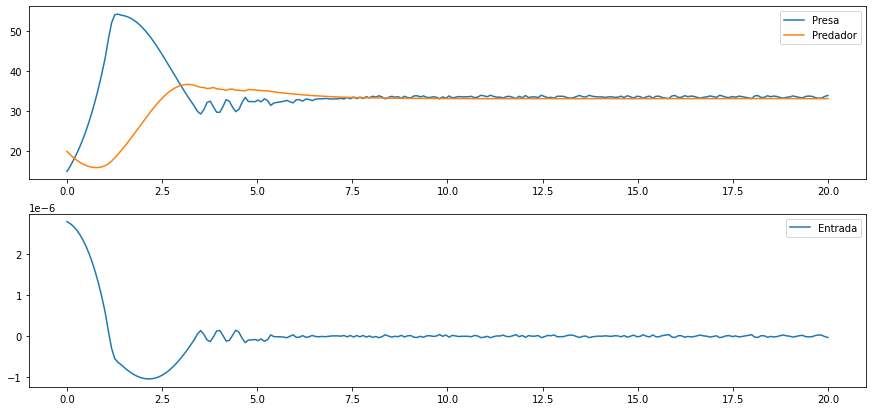

In [76]:
###################################################################################################
# Simulando o sistema

t, y = control.input_output_response(io_closed, T, 30, [15, 20])

# Visualizando o resultado

plt.figure(figsize=(15,7))
plt.subplot(2, 1, 1)
plt.plot(t, y[0])
plt.plot(t, y[1])
plt.legend(['Presa', 'Predador'])
plt.subplot(2, 1, 2)
plt.plot(t, y[2])
plt.legend(['Entrada'])
plt.show(block=False)

# **Sintonia dos coeficientes**

In [ ]:
###################################################################################################
# Simulando o sistema

import scipy.optimize

banana = lambda x: 100*(x[1]-x[0]**2)**2+(1-x[0])**2
xopt = scipy.optimize.fmin(func=banana, x0=[-1.2,1])

In [176]:
###################################################################################################
# Modifica o modelo - generalizando

def presa_predador(t,x,u,parametros):
  """ cria o modelo não linear do fenômeno"""

  # Parâmetros iniciais
  a = parametros.get('a')
  b = parametros.get('b')
  c = parametros.get('c')
  d = parametros.get('d')
  u_0 = 0

  # Iniciar os valores de lebres e linces - x_o =[xo1 xo2].T
  H = x[0];
  L = x[1];

  # entrada do sistema - adicionar comida - nunca retirar
  u = u_0 if u > 0 else 0 

  # determinar as equações
  dH = (a + u)*H -b*H*L
  dL = -c*L + d*H*L

  return [dH,dL]

In [177]:
###################################################################################################
# Cria o subsistema correspondente

# Syntaxe: io_sys = NonlinearIOSystem(updfcn, outfcn, inputs=M, outputs=P, states=N)

io_modelo = control.NonlinearIOSystem(
    presa_predador, None, inputs=('u'), outputs=('H', 'L'),
    states=('H', 'L'), params={}, name='modeloPP')

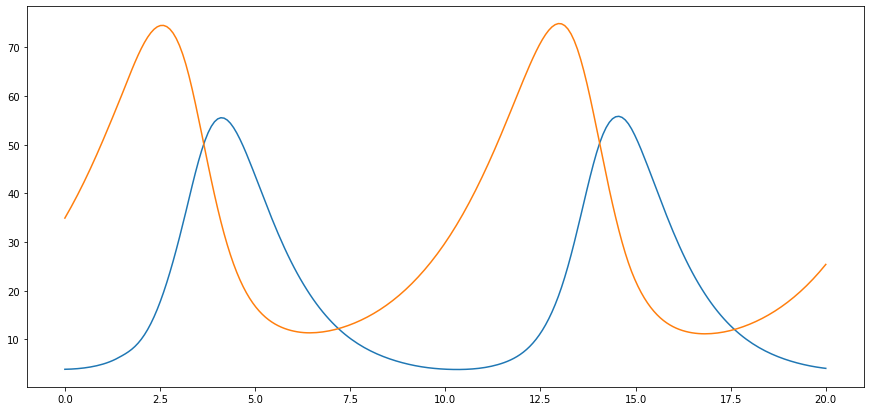

In [178]:
###################################################################################################
# Testando o modelo em simulação

###################################################################################################
# Simulação

x0 = [34.9134,3.8566] 

# Cálculo no tempo

parametros = {'a':0.48069,'b':0.024822,'c':0.92718,'d':0.027564}

# syntaxe : t, y = input_output_response(io_sys, T, U, X0, params)

t, saida = control.input_output_response(io_modelo, np.linspace(0,20,240), 0, x0,parametros)

plt.figure(figsize=(15,7))
plt.plot(t,saida[1]) # Lebres
plt.plot(t,saida[0]) # Linces
plt.show()

Para estimarmos os parâmetros do modelo , vamos utilizar  inicialmente o método de mínimos quadrados. Podemos então formular o problema a partir da Equação abaixo. Na Equação $y_m(k)$ representa o dado real em cada amostra $k$; $y_s(\theta,k)$ representa o **valor estimado** a partir da simulação do modelo para uma determinada amostra $k$ e $\theta$ representa o vetor ed parâmetros $\theta = [ \alpha \; \; \beta \; \; \gamma \; \; \delta \; \; x(0) \; \; x(1) ]^T$. 

$$ min_{\theta}= \sum_{k=1}^{K}(y_m(k) - y_s(\theta,k))^2 $$

A equação formula a pergunta: quais os valores de  $\alpha \; \; \beta \; \; \gamma \; \; \delta \; \; x(0) \; \; x(1) $ que minizam o erro quadrático quando comparados com os dados reais.

In [193]:
###################################################################################################
# Determina a função mérito

def ErroQuadratico(Hn,Ln,tn,x0,u,parametros):
    """ function to pass to optimize.leastsq
        The routine will square and sum the values returned by 
        this function""" 
    t, y = control.input_output_response(io_modelo, tn, u, x0,parametros)
    erroH = y[0] - Hn
    erroL = y[1] - Ln
    EQ = np.sum((np.concatenate([erroH,erroL])**2))
    return EQ

def objetivo(p):
  parametros = {'a':p[0],'b':p[1],'c':p[2],'d':p[3]}
  xi = [p[4],p[5]]
  return ErroQuadratico(np.array(Hn),np.array(Ln),np.array(tn),xi,0,parametros)

In [195]:
import scipy.optimize

x0=[0.453,0.0205,0.79,0.0229,34.6,22.1]

xopt = scipy.optimize.fmin(func=objetivo, x0=[0.453,0.0205,0.79,0.0229,34.6,22.1])

Optimization terminated successfully.
         Current function value: 596.541693
         Iterations: 616
         Function evaluations: 956


In [196]:
xopt

array([4.62487192e-01, 2.42572189e-02, 9.66411247e-01, 2.85838879e-02,
       3.53403078e+01, 3.59287407e+00])

#**Referências**

https://python-control.readthedocs.io/_/downloads/en/0.9.0/pdf/

https://stackoverflow.com/questions/19070943/numpy-scipy-analog-of-matlabs-fminsearch